# Unsupervised Theme Discovery for Supply-Chain Sustainability Texts


This notebook helps you discover data-driven themes in your corpus (e.g., 700 story + response pairs).
It follows a **map → cluster → label** pattern using text embeddings and clustering, then surfaces
representative quotes and exports results for further analysis.

**What you'll get**
- Cleaned corpus (merging story and response text per case)
- Vector embeddings (Sentence-Transformers or OpenAI embeddings)
- Dimensionality reduction (UMAP) for visualization
- Clustering (HDBSCAN by default; k-means as a fallback)
- Automatic keyword-based labels per cluster (c-TF-IDF)
- Representative quotes/examples per cluster
- CSV exports you can use downstream

> Tip: Treat this as *broad discovery*; you'll later do schema-based extraction for your RQs.


In [2]:
# Read in data
import pandas as pd

df = pd.read_csv("C:/Users/bscherrer/Documents/snf-project3/data/prepared_df.csv")  # Replace with your actual file path
df[["Companies", "text", "date"]].head(3)

,Companies,text,date
0,Shell plc,We wish to state categorically that there was ...,2009-06-02
1,Shell plc,The report makes assumptions about investment ...,2009-07-08
2,Shell plc,"For many years, MOSOP has claimed that SPDC [S...",2006-11-08


## 3) Create embeddings

Two options:
1. **Sentence-Transformers** (default, local): e.g., `all-MiniLM-L6-v2` (fast) or `all-mpnet-base-v2` (higher quality).
2. **OpenAI embeddings** (optional): requires API key; can be helpful if you already use their stack.

We'll implement Sentence-Transformers first, with a toggle to switch.


In [10]:
# === Embeddings (Sentence-Transformers by default) ===
USE_OPENAI = False  # set True to use OpenAI embeddings instead
SENTENCE_MODEL_NAME = "paraphrase-multilingual-mpnet-base-v2"  # or 'all-mpnet-base-v2'

embeddings = None

if not USE_OPENAI:
    from sentence_transformers import SentenceTransformer
    from tqdm import tqdm

    model = SentenceTransformer(SENTENCE_MODEL_NAME)
    texts = df["text"].tolist()
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

    # unpack the nested embeddings and add to dataframe
    df['embedding_framing'] = [d[0] for d in embeddings]
else:
    # OpenAI path (optional). Requires OPENAI_API_KEY in env.
    # from openai import OpenAI
    # client = OpenAI()
    # def get_openai_embeds(batch):
    #     resp = client.embeddings.create(
    #         model="text-embedding-3-large",
    #         input=batch
    #     )
    #     return np.array([d.embedding for d in resp.data], dtype="float32")
    # # Batch and call API here...
    raise NotImplementedError("Set USE_OPENAI=False or implement your OpenAI embedding code.")
    
print("Embedding shape:", None if embeddings is None else embeddings.shape)

Batches: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it]

Embedding shape: (427, 768)


## 4) Dimensionality reduction (UMAP)

In [18]:
# Reduce to 15D for clustering stability
from umap.umap_ import UMAP
import numpy as np

# Reduce the dimensions of the embeddings to 30
X = np.vstack(df['embedding_framing'].values)

# UMAP with 30 dimensions
umap_30d = UMAP(n_components=30, random_state=42, metric='cosine')

X_30d = umap_30d.fit_transform(X)


c:\Users\bscherrer\AppData\Local\miniconda3\envs\scrape-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## 5) Clustering

- **HDBSCAN** (density-based, auto-detects number of clusters, handles noise)
- Fallback: **k-means** (requires `n_clusters` choice)

We save `cluster_id` per document. HDBSCAN may assign `-1` to noise.


In [32]:
from sklearn.cluster import AgglomerativeClustering


# === Clustering (HDBSCAN with fallback to k-means) ===
# cluster_labels = None
# algo = None

# try:
#     import hdbscan
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=None, metric='euclidean')
#     cluster_labels = clusterer.fit_predict(X_30d)  # or embeddings directly
#     algo = "hdbscan"
#     print("HDBSCAN clusters (incl. noise=-1):", len(set(cluster_labels)))

#     import numpy as np
#     print(np.unique(cluster_labels, return_counts=True))
# except Exception as e:
#     print("HDBSCAN unavailable or failed:", e)
#     # Fallback to k-means with a heuristic k
#     from sklearn.cluster import KMeans
#     k = max(5, int(math.sqrt(len(df)) // 2))  # rough heuristic, tune as needed
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
#     cluster_labels = kmeans.fit_predict(X_hd)
#     algo = "kmeans"
#     print("KMeans clusters:", k)

# Cluster the embeddings using agglomerative clustering to 40 clusters
aggc = AgglomerativeClustering(
    n_clusters=20,
    metric='euclidean',
    compute_full_tree=True,
    linkage='ward'
)

aggc.fit(X_30d)
df['cluster_id'] = aggc.labels_.astype(str)


df["cluster_id"].value_counts().sort_index().head(20)


cluster_id
0     30
1     19
10    11
11    16
12    15
13    23
14     9
15    13
16     8
17    16
18    12
19    13
2     22
3     60
4     19
5     22
6     29
7     22
8     17
9     51
Name: count, dtype: int64

In [22]:
# === UMAP dimensionality reduction for plotting ===
from umap.umap_ import UMAP
import plotly.express as px
import hdbscan
from sklearn.cluster import AgglomerativeClustering


df_plot = df.copy()

# Cluster the embeddings using agglomerative clustering to 40 clusters
aggc = AgglomerativeClustering(
    n_clusters=5,
    metric='euclidean',
    compute_full_tree=True,
    linkage='ward'
)

aggc.fit(X_30d)

df_plot["cluster_labels"] = aggc.labels_.astype(str)

# reduce to 3 dimensions for 3D plotting
umap_3d = UMAP(n_components=3, random_state=42)
X_3d = umap_3d.fit_transform(embeddings)
df_plot["umap_x"] = X_3d[:,0]
df_plot["umap_y"] = X_3d[:,1]
df_plot["umap_z"] = X_3d[:,2]

fig = px.scatter_3d(
    df_plot,
    x='umap_x',
    y='umap_y',
    z='umap_z',
    color = 'cluster_labels',
    hover_data={'cluster_labels': True},           # show text on hover
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=2, opacity=0.8))
fig.show()


c:\Users\bscherrer\AppData\Local\miniconda3\envs\scrape-env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## 6) Topic labels (c-TF-IDF)

We compute per-cluster "class-based TF-IDF" keywords and short labels. This approximates BERTopic's labeling step.
Later, you may refine labels with an LLM (optional cell below).


In [13]:
# === c-TF-IDF keyword extraction per cluster ===
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def c_tf_idf(corpus, m, ngram_range=(1,2), min_df=2):
    # corpus: list of concatenated documents per class
    vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=min_df, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
    tf_idf = transformer.fit_transform(X)
    # scale by class lengths (m = total documents)
    tf_idf = tf_idf / m
    return tf_idf, vectorizer

def top_terms_per_class(tf_idf, vectorizer, topk=15):
    terms = np.array(vectorizer.get_feature_names_out())
    tops = []
    for row in tf_idf:
        idx = np.argsort(row.toarray()[0])[::-1][:topk]
        tops.append(terms[idx].tolist())
    return tops

# Build class documents: concatenate texts per cluster
clusters = sorted(df["cluster_id"].dropna().unique().tolist())
cluster_texts = []
cluster_sizes = []

for c in clusters:
    texts_c = df.loc[df["cluster_id"]==c, "text"].astype(str).tolist()
    cluster_sizes.append(len(texts_c))
    cluster_texts.append(" \n ".join(texts_c) if texts_c else "")

tfidf_mat, vect = c_tf_idf(cluster_texts, m=len(df), ngram_range=(1,2), min_df=2)
keywords_per_cluster = top_terms_per_class(tfidf_mat, vect, topk=15)

cluster_labels_map = {}
for c, kws in zip(clusters, keywords_per_cluster):
    # Create a simple label from top 3 keywords
    label = ", ".join(kws[:3]) if kws else "misc"
    cluster_labels_map[c] = {"label": label, "keywords": kws}

# Attach labels
df["cluster_label"] = df["cluster_id"].map(lambda c: cluster_labels_map.get(c, {}).get("label", "misc"))
df[["doc_id","cluster_id","cluster_label"]].head(10)


,doc_id,cluster_id,cluster_label
0,doc_0000,-1,"rights, en, la"
1,doc_0001,2,"da, vale, em"
2,doc_0002,2,"da, vale, em"
3,doc_0003,1,"rights, human, workers"
4,doc_0004,2,"da, vale, em"
5,doc_0005,2,"da, vale, em"
6,doc_0006,1,"rights, human, workers"
7,doc_0007,1,"rights, human, workers"
8,doc_0008,2,"da, vale, em"
9,doc_0009,2,"da, vale, em"


## 7) Representative quotes / examples

For each cluster, surface a few short snippets from the most central documents (centroid-based for k-means;
for HDBSCAN, we pick documents with high membership probability if available, else nearest to cluster centroid in embedding space).


In [14]:
# === Representative snippets per cluster ===
from sklearn.metrics import pairwise_distances
import numpy as np

def get_representatives(emb_matrix, ids, n=5):
    # pick n docs closest to centroid
    if len(ids) == 0:
        return []
    idx = np.array(ids)
    centroid = emb_matrix[idx].mean(axis=0, keepdims=True)
    dists = pairwise_distances(emb_matrix[idx], centroid, metric="euclidean").ravel()
    order = np.argsort(dists)
    return idx[order][:n].tolist()

def shorten(text, n=240):
    s = re.sub(r"\s+", " ", text).strip()
    return (s[:n] + "…") if len(s) > n else s

cluster_summaries = []
for c in clusters:
    doc_idx = df.index[df["cluster_id"]==c].tolist()
    rep_idx = get_representatives(embeddings, doc_idx, n=5)
    reps = []
    for ridx in rep_idx:
        row = df.iloc[ridx]
        # use part of response_text if available, else combined text
        base = row.get("response_text", "") or row["text"]
        reps.append({
            "doc_id": row["doc_id"],
            "snippet": shorten(base, 280)
        })
    cluster_summaries.append({
        "cluster_id": int(c),
        "size": int(len(doc_idx)),
        "label": cluster_labels_map.get(c, {}).get("label", "misc"),
        "keywords": cluster_labels_map.get(c, {}).get("keywords", []),
        "representatives": reps
    })

# Preview a couple of clusters
cluster_summaries[:2]


[{'cluster_id': -1,
  'size': 18,
  'label': 'rights, en, la',
  'keywords': ['rights',
   'en',
   'la',
   'nestlé',
   'human rights',
   'human',
   'indigenous',
   'et',
   'violence',
   '2014',
   'sinaltrainal',
   'shell',
   'colombia',
   'les',
   'josé'],
  'representatives': [{'doc_id': 'doc_0147',
    'snippet': 'Colombia: trade unionist attacked, life at risk, Amnesty International, June 19 2014, http://www.amnesty.org/en/library/asset/AMR23/025/2014/en/f338da48-edf9-4ecb-a7a7- 6e1bff2841b0/amr230252014en.html Background On 16th June 2014, armed assailants confronted an employee of Nestl…'},
   {'doc_id': 'doc_0149',
    'snippet': 'Colombie. Un syndicaliste agressé en danger, Amnesty http://www.amnesty.org/en/library/asset/AMR23/025/2014/en/01a67d11-d57f-40a1-8a99- 1287ea777530/amr230252014fr.html International, Juin 19 2014, Contexte Le 16 juin 2014, des assaillants armés se sont confrontés à un employé de…'},
   {'doc_id': 'doc_0049',
    'snippet': 'We have taken n

## 8) Visualization & exports

- 2D scatter plot of UMAP with cluster IDs
- CSV export: `themes_assignments.csv` and `cluster_summaries.csv` including keywords and representative quotes


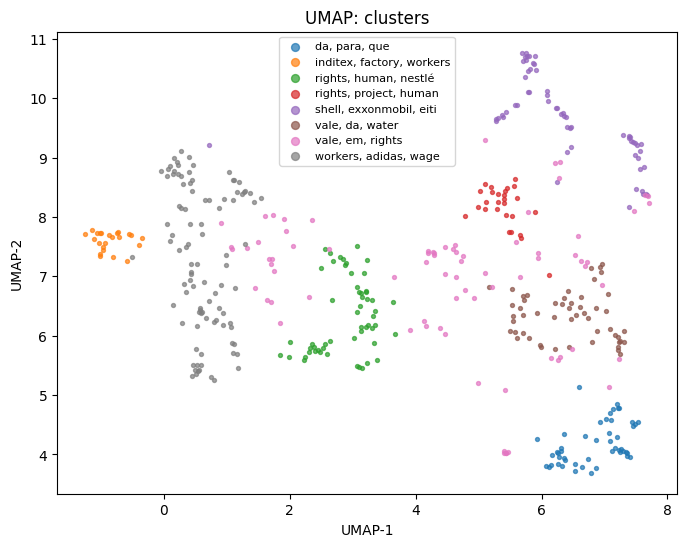

PermissionError: [Errno 13] Permission denied: 'unsup_themes_assignments.csv'

In [62]:
# === Simple 2D scatter plot ===
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
for cid, g in df.groupby("cluster_label"):
    plt.scatter(g["umap_x"], g["umap_y"], s=8, label=str(cid), alpha=0.7)
plt.title("UMAP: clusters")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.legend(markerscale=2, fontsize=8)
plt.show()

# Export results
assign_cols = ["doc_id","Companies","Company Sectors","Company Headquarters","Countries","date","cluster_id","cluster_label","umap_x","umap_y"]
assign_cols = [c for c in assign_cols if c in df.columns]
assign_df = df[assign_cols].copy()
assign_path = f"{SAVE_PREFIX}_assignments.csv"
assign_df.to_csv(assign_path, index=False)

# Summaries export
import json
summ_path = f"{SAVE_PREFIX}_cluster_summaries.json"
with open(summ_path, "w", encoding="utf-8") as f:
    json.dump(cluster_summaries, f, ensure_ascii=False, indent=2)

assign_path, summ_path


# More plots

Text(0.5, 0, 'Year')

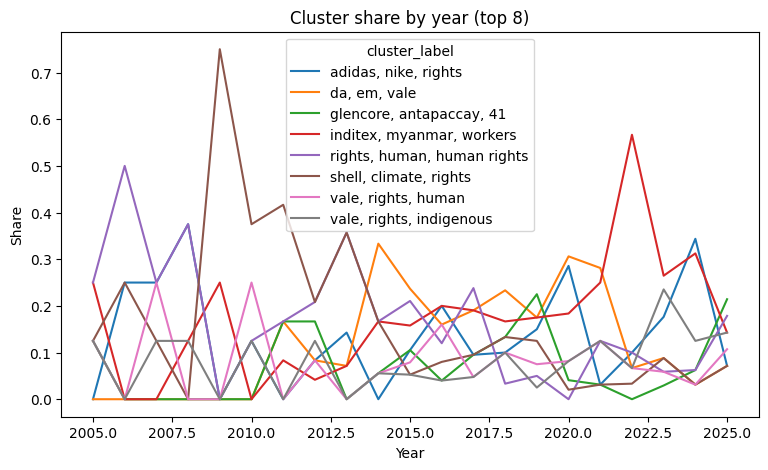

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year.astype(int)

top_clusters = df["cluster_label"].value_counts().head(8).index
sub = df[df["cluster_label"].isin(top_clusters)]
ts = sub.pivot_table(index="year", columns="cluster_label", values="doc_id", aggfunc="count", fill_value=0)
ts = ts.div(ts.sum(axis=1), axis=0)  # share by year
ts.index = ts.index.round().astype(int)
ts.plot(figsize=(9,5))
plt.title("Cluster share by year (top 8)"); plt.ylabel("Share"); plt.xlabel("Year")


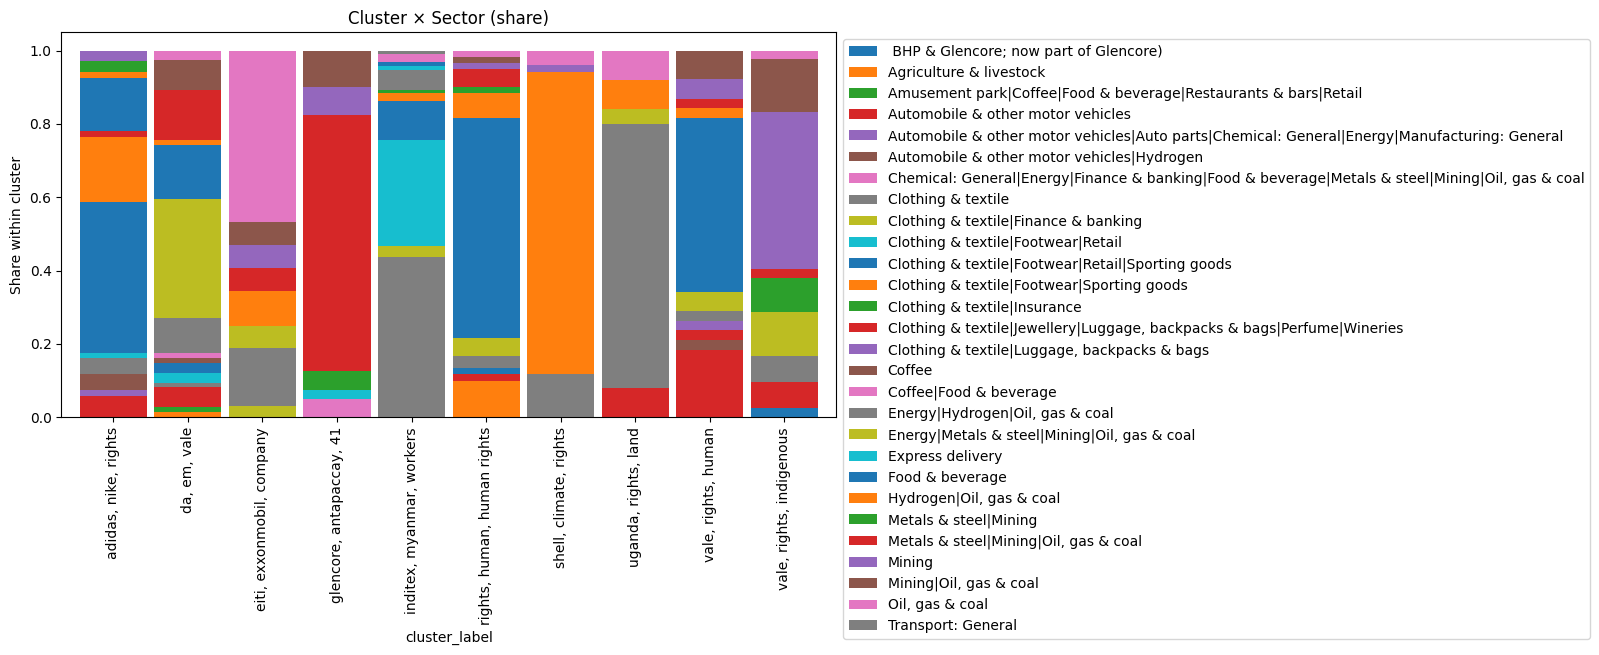

In [48]:
tab = (df.pivot_table(index="cluster_label", columns="Company Sectors", values="doc_id", aggfunc="count", fill_value=0))
(tab.div(tab.sum(axis=1), axis=0)).plot(kind="bar", stacked=True, figsize=(10,5), width=0.9)
plt.title("Cluster × Sector (share)"); plt.ylabel("Share within cluster"); plt.legend(bbox_to_anchor=(1,1))


## 9) (Optional) LLM-assisted labeling

If you want nicer human-readable labels, call an LLM with each cluster's top keywords and 2–3 example snippets.
This cell is optional and requires an API key (commented by default).


In [51]:
# === Optional: LLM-assisted label refinement (commented) ===
# This cell sends top keywords + representative snippets to an LLM to produce cleaner labels.
# Requires OPENAI_API_KEY in your environment.
#
from openai import OpenAI
import json

client = OpenAI()

def refine_label(keywords, reps):
    prompt = f"""
    You are labeling a text cluster from corporate sustainability responses.
    Here are the top keywords: {', '.join(keywords)}
    Here are representative snippets:
    {chr(10).join('- ' + r['snippet'] for r in reps)}
    Suggest a short, human-readable label (max 6 words) and a one-sentence description.
    Respond as JSON with keys: label, description.
    """
    resp = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role":"user","content":prompt}],
        temperature=0.2
    )
    content = resp.choices[0].message.content
    print(content)
    match = re.search(r"\{.*\}", content, re.DOTALL)
    if match:
        return json.loads(match.group(0))
    else:
        raise ValueError("No valid JSON found in LLM response")

refined = {}
for cs in cluster_summaries:
    refined[cs["cluster_id"]] = refine_label(cs["keywords"], cs["representatives"])

refined
               


```json
{
  "label": "Corporate Human Rights Engagement",
  "description": "Responses from corporations addressing human rights and environmental impacts on local and indigenous communities in mining projects."
}
```
```json
{
  "label": "Corporate Human Rights Practices",
  "description": "This cluster focuses on corporate responses to human rights and labor issues in their supply chains, particularly involving Adidas and Nike."
}
```
```json
{
  "label": "Corporate Transparency in Extractive Industries",
  "description": "This cluster focuses on corporate commitments and responses related to transparency, anti-corruption, and human rights in the extractive industries, highlighting the role of major companies like ExxonMobil and BHP in promoting ethical business practices."
}
```
```json
{
  "label": "Vale's Human Rights Responses",
  "description": "Communications from Vale addressing human rights allegations and clarifying their corporate sustainability efforts."
}
```
```json
{
  "

{0: {'label': 'Corporate Human Rights Engagement',
  'description': 'Responses from corporations addressing human rights and environmental impacts on local and indigenous communities in mining projects.'},
 1: {'label': 'Corporate Human Rights Practices',
  'description': 'This cluster focuses on corporate responses to human rights and labor issues in their supply chains, particularly involving Adidas and Nike.'},
 2: {'label': 'Corporate Transparency in Extractive Industries',
  'description': 'This cluster focuses on corporate commitments and responses related to transparency, anti-corruption, and human rights in the extractive industries, highlighting the role of major companies like ExxonMobil and BHP in promoting ethical business practices.'},
 3: {'label': "Vale's Human Rights Responses",
  'description': 'Communications from Vale addressing human rights allegations and clarifying their corporate sustainability efforts.'},
 4: {'label': 'Corporate Human Rights Responses',
  'desc